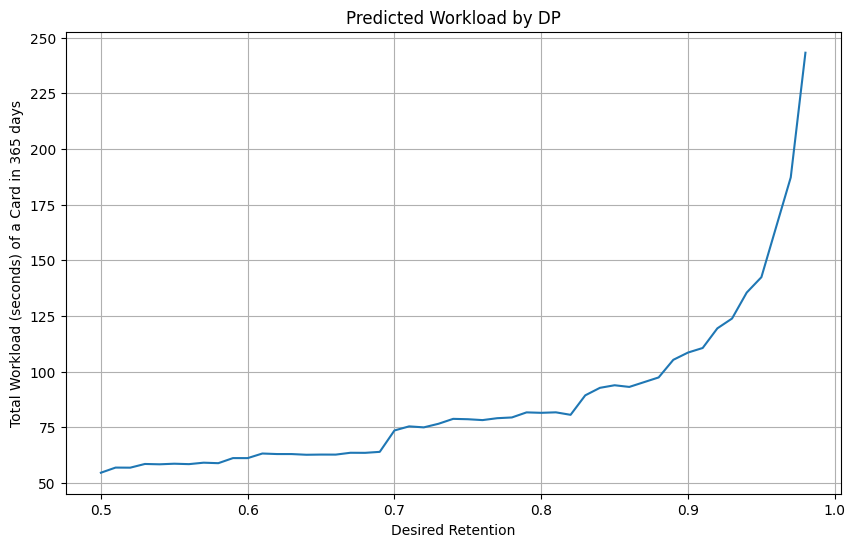

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from fsrs_optimizer import DEFAULT_PARAMETER


learn_days = 365
FORGET_COST = 23.185
RECALL_COST = 7.8454
LEARN_COST = 19.4698

R_RANGE = np.arange(0.5, 0.99, 0.01)


S_MIN = 0.001
S_MAX = 365
SHORT_STEP = np.log(2) / 10
LONG_STEP = 10

D_MIN = 1
D_MAX = 10
D_EPS = 0.5


class WorkloadEstimator:
    def __init__(
        self,
        review_costs,
        review_rating_prob,
        w,
    ):
        self.review_costs = review_costs
        self.review_rating_prob = review_rating_prob
        self.w = w

        # Initialize state spaces
        self._init_state_spaces()

    def power_forgetting_curve(self, t, s, decay):
        factor = 0.9 ** (1 / decay) - 1
        return (1 + factor * t / s) ** decay

    def stability_after_success(self, s, d, r, g):
        """Calculate stability after a successful review."""
        return s * (
            1
            + np.exp(self.w[8])
            * (11 - d)
            * np.power(s, -self.w[9])
            * (np.exp((1 - r) * self.w[10]) - 1)
            * (self.w[15] if g == 2 else 1)
            * (self.w[16] if g == 4 else 1)
        )

    def stability_after_failure(self, s, d, r):
        """Calculate stability after a failed review."""
        return np.maximum(
            self.s_min,
            np.minimum(
                self.w[11]
                * np.power(d, -self.w[12])
                * (np.power(s + 1, self.w[13]) - 1)
                * np.exp((1 - r) * self.w[14]),
                s / np.exp(self.w[17] * self.w[18]),
            ),
        )

    def stability_short_term(self, s):
        """Calculate short-term stability."""
        rating = 3
        sinc = np.exp(self.w[17] * (rating - 3 + self.w[18])) * np.power(s, -self.w[19])
        return s * sinc

    def init_s(self, rating):
        """Initialize stability for a given rating."""
        return np.choose(rating - 1, np.array(self.w[0:4]))

    def init_d(self, rating):
        """Initialize difficulty for a given rating."""
        return self.w[4] - np.exp(self.w[5] * (rating - 1)) + 1

    def linear_damping(self, delta_d, old_d):
        """Apply linear damping to difficulty change."""
        return delta_d * (10 - old_d) / 9

    def next_d(self, d, g):
        """Calculate next difficulty after a review."""
        delta_d = -self.w[6] * (g - 3)
        new_d = d + self.linear_damping(delta_d, d)
        new_d = self.mean_reversion(self.init_d(4), new_d)
        return new_d.clip(1, 10)

    def mean_reversion(self, init, current):
        """Apply mean reversion to difficulty."""
        return self.w[7] * init + (1 - self.w[7]) * current

    def s2i(self, s):
        """Convert stability to index."""
        result = np.zeros_like(s, dtype=int)
        small_mask = s <= self.s_mid

        # Handle small values (logarithmic scale)
        result[small_mask] = np.clip(
            np.ceil(
                (np.log(s[small_mask]) - np.log(self.s_min)) / self.short_step
            ).astype(int),
            0,
            len(self.s_state_small) - 1,
        )

        # Handle large values (linear scale)
        result[~small_mask] = len(self.s_state_small) + np.clip(
            np.ceil(
                (s[~small_mask] - self.s_state_small[-1] - self.long_step)
                / self.long_step
            ).astype(int),
            0,
            len(self.s_state_large) - 1,
        )

        return result

    def d2i(self, d):
        """Convert difficulty to index."""
        return np.clip(
            np.floor((d - self.d_min) / (self.d_max - self.d_min) * self.d_size).astype(
                int
            ),
            0,
            self.d_size - 1,
        )

    def _init_state_spaces(
        self,
        s_min=S_MIN,
        s_max=S_MAX,
        short_step=SHORT_STEP,
        long_step=LONG_STEP,
        d_min=D_MIN,
        d_max=D_MAX,
        d_eps=D_EPS,
        t_min=0,
        t_max=learn_days,
    ):
        # Stability state space
        self.s_min = s_min
        self.s_max = s_max
        self.short_step = short_step
        self.long_step = long_step
        self.s_mid = min(self.long_step / (1 - np.exp(-self.short_step)), self.s_max)

        self.s_state_small = np.exp(
            np.arange(np.log(self.s_min), np.log(self.s_mid), self.short_step)
        )
        self.s_state_large = np.arange(
            max(self.s_state_small) + self.long_step, self.s_max, self.long_step
        )
        self.s_state = np.concatenate([self.s_state_small, self.s_state_large])
        self.s_size = len(self.s_state)

        # Difficulty state space
        self.d_min = d_min
        self.d_max = d_max
        self.d_eps = d_eps
        self.d_size = np.ceil((self.d_max - self.d_min) / self.d_eps + 1).astype(int)
        self.d_state = np.linspace(self.d_min, self.d_max, self.d_size)

        # Time state space
        self.t_min = t_min
        self.t_max = t_max
        self.t_size = t_max - t_min
        self.t_state = np.arange(self.t_min, self.t_max)

        # Initialize matrices
        self.cost_matrix = np.zeros((self.s_size, self.d_size, self.t_size + 1))
        self.cost_matrix[:, :, -1] = 0

        # Create meshgrids
        self.s_state_mesh_2d, self.d_state_mesh_2d = np.meshgrid(
            self.s_state, self.d_state, indexing="ij"
        )

    def next_interval(self, s, r, decay):
        factor = 0.9 ** (1.0 / decay) - 1.0
        ivl = s / factor * (r ** (1.0 / decay) - 1.0)
        return np.maximum(1, np.floor(ivl))

    def evaluate_desired_retention(self, desired_retention):
        """Evaluate the cost and retention for a given r threshold."""
        self.r_state_mesh_2d = desired_retention * np.ones((self.s_size, self.d_size))
        self.s_state_mesh_2d, self.d_state_mesh_2d = np.meshgrid(
            self.s_state, self.d_state, indexing="ij"
        )
        ivl_mesh = self.next_interval(
            self.s_state_mesh_2d, self.r_state_mesh_2d, -self.w[20]
        )
        self.r_state_mesh_2d = self.power_forgetting_curve(
            ivl_mesh, self.s_state_mesh_2d, -self.w[20]
        )
        precomputed_transitions = np.zeros(
            (4, 2, self.s_size, self.d_size), dtype=np.float64
        )

        # Again case
        precomputed_transitions[0, 0, :, :] = self.stability_after_failure(
            self.s_state_mesh_2d, self.d_state_mesh_2d, self.r_state_mesh_2d
        )
        precomputed_transitions[0, 1, :, :] = self.next_d(self.d_state_mesh_2d, 1)

        # Calculate costs for each rating
        for rating in [2, 3, 4]:
            next_s = self.stability_after_success(
                self.s_state_mesh_2d, self.d_state_mesh_2d, self.r_state_mesh_2d, rating
            )
            next_d = self.next_d(self.d_state_mesh_2d, rating)
            precomputed_transitions[rating - 1, 0, :, :] = next_s
            precomputed_transitions[rating - 1, 1, :, :] = next_d

        for t in range(self.t_size - 1, -1, -1):
            current_cost_slice = np.zeros_like(self.cost_matrix[:, :, t])
            for rating in range(1, 5):
                next_s = precomputed_transitions[rating - 1, 0, :, :]
                interval = self.next_interval(next_s, desired_retention, -self.w[20])
                next_t_mesh_2d = np.minimum(t + interval, self.t_size).astype(int)
                next_d = precomputed_transitions[rating - 1, 1, :, :]
                transition_prob = (
                    (1 - self.r_state_mesh_2d)
                    if rating == 1
                    else self.r_state_mesh_2d * self.review_rating_prob[rating - 2]
                )
                future_costs = (
                    self._get_cost(next_s, next_d, next_t_mesh_2d) * transition_prob
                )
                current_cost = self.review_costs[rating - 1] * transition_prob
                current_cost_slice += future_costs + current_cost
            self.cost_matrix[:, :, t] = current_cost_slice

        return self.cost_matrix

    def _get_cost(self, s, d, t):
        """Get cost from cost matrix for given stability and difficulty."""
        return self.cost_matrix[self.s2i(s), self.d2i(d), t]


DEFAULT_REVIEW_COSTS = np.array([FORGET_COST, 0, RECALL_COST, 0])
DEFAULT_REVIEW_RATING_PROB = np.array([0, 1, 0])


estimator = WorkloadEstimator(
    review_costs=DEFAULT_REVIEW_COSTS,
    review_rating_prob=DEFAULT_REVIEW_RATING_PROB,
    w=DEFAULT_PARAMETER,
)
init_stabilities = estimator.init_s(np.array([1, 3]))
init_difficulties = estimator.init_d(np.array([1, 3]))
workload_list = []
plt.figure(figsize=(10, 6))

for desired_retention in R_RANGE:
    result = estimator.evaluate_desired_retention(desired_retention)
    init_cost = result[
        estimator.s2i(init_stabilities), estimator.d2i(init_difficulties), 0
    ]
    workload_list.append(init_cost @ np.array([0.2, 0.8]) + LEARN_COST)

plt.plot(R_RANGE, workload_list)
plt.grid(True)
plt.title("Predicted Workload by DP")
plt.xlabel("Desired Retention")
plt.ylabel(f"Total Workload (seconds) of a Card in {learn_days} days")
plt.show()